# Planning and Reasoning Project
## Path Planning with Dynamic Obstacles using Velocity Obstacles (VO) and Nonlinear Model Predictive Control (NMPC)
**Leandro Maglianella - 1792507**

> *This project is supposed to be executed in Google Colab*






## Import

In [ ]:
! rm -rf sample_data

# main libraries for the task
import numpy as np
np.random.seed(0)
from scipy.optimize import minimize, Bounds

# random for random theta for obstacles' configuration "random"
import random
random.seed(0)
# tqdm to monitor advancements
from tqdm import tqdm

# create_video libraries
from google.colab import files
import datetime
import cv2
import glob
import os
import math

# plots
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Circle
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure

print('Libraries imported.')

Libraries imported.


## Definitions

### Obstacle Class

This class creates a dynamic round obstacle:
   - in position $p_0$
   - moving in linear motion with velocity $v$
   - direction given by $\theta$


In [ ]:
class Obstacle:
  def __init__(self, p0, v, theta):
    self.positions = np.tile(p0, (NUMBER_OF_TIMESTEPS, 1))

    vx = v * np.cos(theta)
    vy = v * np.sin(theta)
    v = np.stack([vx, vy])
    self.velocities = np.tile(v, (NUMBER_OF_TIMESTEPS, 1))

    for step in range(1, NUMBER_OF_TIMESTEPS):
      # direction inversion if the obstacle is escaping the relevant area
      if (self.positions[step-1]>ENVIRONMENT_DIM-0.5).any() or (self.positions[step-1]<0.5).any():
        self.velocities[step:] = -self.velocities[step]
      self.positions[step] = self.positions[step-1] + self.velocities[step]*TIMESTEP

### Create Obstacles Functions

In [ ]:
# create n obstacles in random positions and random directions
def create_random_obstacles(n):
  obstacles = []
  for _ in range(n):
    obstacle_vel = 2
    # p0 not in the middle (otherwise robot and obstacles overlap at the start in the "stay still" environment)
    p0 = np.random.rand(2)*(ENVIRONMENT_DIM-2)+1
    while (p0 >= 3.5).all() and (p0 <= 6.5).all():
      p0 = np.random.rand(2)*(ENVIRONMENT_DIM-2)+1
    # direction towards the environment's center (to stay some time inside the relevant area)
    if p0[0] <= ENVIRONMENT_DIM/2:
      if p0[1] <= ENVIRONMENT_DIM/2:
        theta = random.random()*np.pi/2
      else:
        theta = -random.random()*np.pi/2
    else:
      if p0[1] <= ENVIRONMENT_DIM/2:
        theta = np.pi/2+random.random()*np.pi/2
      else:
        theta = -np.pi/2-random.random()*np.pi/2
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  return obstacles

# create 4 pairs of synchronized dynamic obstacles
def create_synchronized_obstacles():
  obstacles = []
  obstacle_vel = VMAX
  for i in range(4):
    px = 0.5 if i%2==0 else 9.5
    p0 = np.array([px, 2.5+(i*2)])
    theta = 0 if i%2==0 else np.pi
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  for i in range(4):
    py = 9.5 if i%2==0 else 0.5
    p0 = np.array([2.5+(i*2), py])
    theta = -np.pi/2 if i%2==0 else np.pi/2
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  global N_OBSTACLES
  N_OBSTACLES = len(obstacles)
  return obstacles

# environment with obstacles with different radii (nmpc fails)
def create_different_obstacles():
  obstacles = []
  obstacle_vel = VMAX
  theta = 0
  global ENVIRONMENT_DIM
  ENVIRONMENT_DIM = 20
  # ob1
  p0 = np.array([10, 10])
  ob = Obstacle(p0, 0, theta)
  obstacles.append(ob)
  # ob2
  p0 = np.array([3, 10])
  ob = Obstacle(p0, 0, theta)
  obstacles.append(ob)
  # ob3
  p0 = np.array([17, 10])
  ob = Obstacle(p0, 0, theta)
  obstacles.append(ob)
  # ob4
  p0 = np.array([10, 3])
  ob = Obstacle(p0, 0, theta)
  obstacles.append(ob)
  # ob5
  p0 = np.array([10, 17])
  ob = Obstacle(p0, 0, theta)
  obstacles.append(ob)
  # dynamic obstacles
  for px in [4.5, 18.5]:
    p0 = np.array([px, 0.5])
    theta = np.pi/2
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  for px in [1.5, 15.5]:
    p0 = np.array([px, 19.5])
    theta = -np.pi/2
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  for py in [4.5, 18.5]:
    p0 = np.array([0.5, py])
    theta = 0
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  for py in [1.5, 15.5]:
    p0 = np.array([19.5, py])
    theta = np.pi
    ob = Obstacle(p0, obstacle_vel, theta)
    obstacles.append(ob)
  global N_OBSTACLES
  N_OBSTACLES = len(obstacles)
  return obstacles

# create an environment with a narrow passage (VO fails)
def create_narrow_obstacles():
  obstacles = []
  obstacle_vel = VMAX
  theta = 0
  global ENVIRONMENT_DIM
  ENVIRONMENT_DIM = 20
  for py in [0.5, 5.5]:
    for i in range (20):
      px = 0.5+i
      if py == 5.5 and (px > 8 and px < 12):
        continue
      p0 = np.array([px, py])
      ob = Obstacle(p0, 0, theta)
      obstacles.append(ob)
  for px in [7.5, 12.5]:
    for py in range (6, 20):
      py = 0.5+py
      if px ==12.5 and py > 16:
        continue
      p0 = np.array([px, py])
      ob = Obstacle(p0, 0, theta)
      obstacles.append(ob)
  for py in range (5):
    py = 0.5+py
    p0 = np.array([19.5, py])
    ob = Obstacle(p0, 0, theta)
    obstacles.append(ob)  
  # dynamic obs
  p0 = np.array([9, 0.5])
  theta = np.pi/2
  ob = Obstacle(p0, obstacle_vel, theta)
  obstacles.append(ob)
  p0 = np.array([11., 19.5])
  theta = -np.pi/2
  ob = Obstacle(p0, obstacle_vel, theta)
  obstacles.append(ob)
  global N_OBSTACLES
  N_OBSTACLES = len(obstacles)
  return obstacles

# create a large version of the "synchronized" configuration
def create_synchronized_big_obstacles():
  obstacles = []
  obstacle_vel = VMAX
  global ENVIRONMENT_DIM
  ENVIRONMENT_DIM = 50
  for j in [0, 20, 40]:
    for i in range(24):
      px = 0.5+j if i%2==0 else 9.5+j
      p0 = np.array([px, 2.5+(i*2)])
      theta = 0 if i%2==0 else np.pi
      ob = Obstacle(p0, obstacle_vel, theta)
      obstacles.append(ob)
  for j in [0, 20, 40]:
    for i in range(24):
      py = 9.5+j if i%2==0 else 0.5+j
      p0 = np.array([2.5+(i*2), py])
      theta = -np.pi/2 if i%2==0 else np.pi/2
      ob = Obstacle(p0, obstacle_vel, theta)
      obstacles.append(ob)
  global N_OBSTACLES
  N_OBSTACLES = len(obstacles)
  return obstacles

### Robot Class

This is the main class, it creates a round robot:
   - in position $p_0$
   - moving with an initial velocity $v_0$ and an initial direction given by $\theta_0$
   - the next $v_i$, with $i \in [1, n_{steps}]$ are decided by one of the two chosen planning algorithm:
    - **Velocity Obstacles** (VO)
    - **Nonlinear Model Predictive Control** (NMPC)

In [ ]:
class Robot:
  def __init__(self, p0, v0, theta0):
    self.positions = np.tile(p0, (NUMBER_OF_TIMESTEPS, 1))

    vx = v0 * np.cos(theta0)
    vy = v0 * np.sin(theta0)
    v = np.stack([vx, vy])
    self.velocities = np.tile(v, (NUMBER_OF_TIMESTEPS, 1))

    if ALGORITHM == 'vo':
      # Create search-space: discrete set of "all possible" velocities executable by the robot
      vels, thetas = np.meshgrid(np.linspace(0, VMAX, 5), np.linspace(0, 2*np.pi, 37))
      vels_x = (vels * np.cos(thetas)).flatten()
      vels_y = (vels * np.sin(thetas)).flatten()
      self.vo_executable_velocities = np.stack((vels_x, vels_y))

    if ALGORITHM == 'nmpc':
      self.nmpc_steps = [NMPC_TIMESTEP*i for i in range(1, HORIZON_LENGTH+1)]
      upper_bound = [(1/np.sqrt(2)) * VMAX] * 2
      lower_bound = [-(1/np.sqrt(2)) * VMAX] * 2
      self.nmpc_bounds = Bounds(lower_bound, upper_bound)

  def update_position(self, step):
    self.positions[step] = self.positions[step-1] + self.velocities[step] * TIMESTEP

  # ------------------------- VELOCITY OBSTACLE METHODS -------------------------

  # find desired velocity (ignoring obstacles)
  def compute_velocity_desired(self, step, goal_pos):
    displacement = goal_pos - self.positions[step-1]
    disp_norm = np.linalg.norm(displacement)
    # did we arrive to the goal?
    if disp_norm < 0.15:
        self.velocities[step] = np.zeros(2)
    else:
        disp_versor = displacement / disp_norm
        self.velocities[step] = VMAX * disp_versor

  # find a safe velocity which is similar to the desired one
  def compute_velocity_safe(self, step, obstacles):
    # constraint matrix and vector
    Amat = np.empty((N_OBSTACLES * 2, 2))
    bvec = np.empty((N_OBSTACLES * 2))
    # Compute constraints for all the dynamic obstacles
    for i, obstacle in enumerate(obstacles):
        # compute theta and phi
        displacement = self.positions[step-1] - obstacle.positions[step]
        disp_norm = np.linalg.norm(displacement)
        thetaBA = np.arctan2(displacement[1], displacement[0])
        if OBSTACLES_CONF == 'different':
          if i == 0:
            disp_norm = ROBOT_RADIUS+4.1 if disp_norm < ROBOT_RADIUS+4.1 else disp_norm
            phi_obst = np.arcsin(ROBOT_RADIUS+4.1/disp_norm)
          elif i <=4:
            disp_norm = ROBOT_RADIUS+1.1 if disp_norm < ROBOT_RADIUS+1.1 else disp_norm
            phi_obst = np.arcsin(ROBOT_RADIUS+1.1/disp_norm)
          else:
            disp_norm = 2.5*ROBOT_RADIUS if disp_norm < 2.5 * ROBOT_RADIUS else disp_norm
            phi_obst = np.arcsin(2.5*ROBOT_RADIUS/disp_norm)
        else:
          disp_norm = 2.5*ROBOT_RADIUS if disp_norm < 2.5 * ROBOT_RADIUS else disp_norm
          phi_obst = np.arcsin(2.5*ROBOT_RADIUS/disp_norm)
        # compute VO left constraints
        phi_left = thetaBA + phi_obst
        Amat[i*2, :] = np.array([np.sin(phi_left), -np.cos(phi_left)])
        bvec[i*2] = Amat[i*2, :] @ obstacle.velocities[step]
        # compute VO right constraints
        phi_right = thetaBA - phi_obst
        Amat[i*2 + 1, :] = np.array([-np.sin(phi_right), np.cos(phi_right)])
        bvec[i*2 + 1] = Amat[i*2 + 1, :] @ obstacle.velocities[step]
    # compute the set of all the safe velocities (i.e. the ones respecting the constraints)
    safe_velocities = self.respect_constraints(self.vo_executable_velocities, Amat, bvec)
    # final choice of safe velocity: the velocity that is closest to the desired one
    size = np.shape(safe_velocities)[1]
    displacements = safe_velocities - np.repeat(self.velocities[step].reshape(2, 1), size, axis=1)
    norms = np.linalg.norm(displacements, axis=0)
    min_index = np.where(norms == np.amin(norms))[0][0]
    self.velocities[step] = safe_velocities[:, min_index]

  def respect_constraints(self, velocities, Amat, bvec):
    for i in range(N_OBSTACLES):
        Amat_temp = Amat[2*i:2*i+2, :]
        bvec_temp = bvec[2*i:2*i+2]
        safe_velocities = []
        # check executable velocities (5*37 available velocities) against the 2 constraints of obstacle i
        # if there is no safe executable velocity, (0, 0) is performed and it is considered as an insecurity
        for i in range(np.shape(velocities)[1]): 
            if not ((Amat_temp @ velocities[:, i] < bvec_temp).all()):
                safe_velocities.append(velocities[:, i])
        velocities = np.array(safe_velocities).T
        if np.shape(velocities) == (0,):
          global UNSAFE_PATH
          UNSAFE_PATH += 1
          return np.zeros((2, 1))
    return velocities

  # ------------------------- NONLINEAR MODEL-PREDICTIVE CONTROL METHODS -------------------------

  # similar to compute_velocity_desired(), compute a desired future trajectoy of HORIZON_LENGTH positions
  def compute_trajectory_desired(self, step, goal_pos):
    start = self.positions[step-1]
    displacement = goal_pos - start
    disp_norm = np.linalg.norm(displacement)
    # did we arrive to the goal?
    if disp_norm < 0.15:
        reference_goal = start
    else:
        disp_versor = displacement / disp_norm
        reference_goal = start + disp_versor * VMAX * NMPC_TIMESTEP * HORIZON_LENGTH
    reference_trajectory = np.linspace(start, reference_goal, HORIZON_LENGTH+1).reshape((2*(HORIZON_LENGTH+1)))[2:]
    self.reference_trajectory = reference_trajectory

  # predict the obstacles' future trajectory of HORIZON_LENGTH positions
  def predict_obstacle_positions(self, step, obstacles):
      self.obstacle_predictions = []
      for obstacle in obstacles:
          obstacle_position = obstacle.positions[step-1]
          obstacle_vel = obstacle.velocities[step-1]
          obstacle_prediction = np.array([obstacle_position+obstacle_vel*i for i in self.nmpc_steps]).flatten()
          self.obstacle_predictions.append(obstacle_prediction)

  # find the velocity with the lowest total cost
  def compute_velocity_heuristic(self, step):
    u0 = np.random.rand(2)
    def cost_fn(u): return self.total_cost(step, u)
    res = minimize(cost_fn, u0, method='SLSQP', bounds=self.nmpc_bounds)
    self.velocities[step] = res.x*VMAX*0.6
    global selected_cost
    selected_cost.append(cost_fn(res.x))

  def total_cost(self, step, u):
    possible_new_robot_pos = np.array([self.positions[step-1]+u*i for i in self.nmpc_steps]).flatten()
    # tracking cost: difference between desired trajectory and trajectory using u
    c1 = np.linalg.norm(possible_new_robot_pos - self.reference_trajectory)
    # collision cost considering each obstacle
    c2 = 0
    # collision cost parameters
    Qc = 5.
    k = 4.
    # for all positions in the horizon
    for i in range(HORIZON_LENGTH):
        # compute collision cost for an obstacle
        for j in range(N_OBSTACLES):
            robot_pos = possible_new_robot_pos[2 * i: 2 * i + 2]
            obstacle_pos = self.obstacle_predictions[j][2 * i: 2 * i + 2]
            displacement = np.linalg.norm(robot_pos - obstacle_pos)
            if OBSTACLES_CONF == 'different':
              if j == 0:
                cost = Qc / (1 + np.exp(k * (displacement - (ROBOT_RADIUS+4.1))))
              elif j <=4:
                cost = Qc / (1 + np.exp(k * (displacement - (ROBOT_RADIUS+1.1))))
              else:
                cost = Qc / (1 + np.exp(k * (displacement - 2*ROBOT_RADIUS)))
            else:
              cost = Qc / (1 + np.exp(k * (displacement - 2*ROBOT_RADIUS)))
            c2 += cost
    return c1 + c2

### Simulate Function

This function execute the whole task:
*   It creates the selected scenario (obstacles configuration)
*   It creates the robot performing the task and sets its start and goal positions
*   It runs the selected algorithm for each timestep (i.e. each frame of the video)



In [ ]:
def simulate(algorithm='vo', ob_conf='random', startx=5, starty=5, goalx=5, goaly=5, n_obstacles=5):
    global UNSAFE_PATH
    UNSAFE_PATH = 0
    global selected_cost
    selected_cost = []
    # create n dynamic obstacles
    if ob_conf == 'random':
      obstacles = create_random_obstacles(n=n_obstacles)

    elif ob_conf == 'synchronized':
      obstacles = create_synchronized_obstacles()
      startx=0.5; starty=0.5; goalx=9.5; goaly=9.5
      
    elif ob_conf == 'different':
      obstacles = create_different_obstacles()
      startx=0.5; starty=0.5; goalx=19.5; goaly=19.5
    
    elif ob_conf == 'narrow':
      obstacles = create_narrow_obstacles()
      startx=2.; starty=2.; goalx=19.5; goaly=19.5

    elif ob_conf == 'synchronized_big':
      obstacles = create_synchronized_big_obstacles()
      startx=0.5; starty=0.5; goalx=49.5; goaly=49.5

    # create the robot
    p0 = np.array([float(startx), float(starty)])
    v0 = 0
    theta0 = 0
    robot = Robot(p0, v0, theta0)

    # goal
    goal_pos = np.array([float(goalx), float(goaly)])

    if algorithm == 'vo':
      # VO path planning
      for step in range(1, NUMBER_OF_TIMESTEPS):
          # preliminary step
          robot.compute_velocity_desired(step, goal_pos)
          # important step
          robot.compute_velocity_safe(step, obstacles)
          # update robot position
          robot.update_position(step)

    elif algorithm == 'nmpc':
      # NMPC path planning
      for step in range(1, NUMBER_OF_TIMESTEPS):
          # preliminary step
          robot.compute_trajectory_desired(step, goal_pos)
          robot.predict_obstacle_positions(step, obstacles)
          # important step
          robot.compute_velocity_heuristic(step)
          # update robot position
          robot.update_position(step)

    else:
      print('Wrong algorithm selected!')

    return obstacles, robot

### Video Function

This function execute a classical routine to generate a video from matplotlib frames:
*   It creates the frame image for each timestep
*   It collects all the frames and merges them together in a video (automatically downloaded)


In [ ]:
# usual video creation routine: matplotlib frames -> video
def create_video(videoname='video.mp4'):
  print('Creating frames...')
  positions = []
  print_path = True
  for i in tqdm(range(NUMBER_OF_TIMESTEPS)):
    plt.clf()
    # adjust visible area
    plt.xlim([0, ENVIRONMENT_DIM])
    plt.ylim([0, ENVIRONMENT_DIM])
    plt.gca().set_aspect('equal', adjustable='box')
    # draw dynamic obstacles
    j = 0
    for obs in obstacles:
      if OBSTACLES_CONF == 'different':
        if j == 0:
          frame_obs = Circle(obs.positions[i], 4, facecolor='red', edgecolor='black')
          plt.gca().add_patch(frame_obs)
        elif j <=4:
          frame_obs = Circle(obs.positions[i], 1, facecolor='red', edgecolor='black')
          plt.gca().add_patch(frame_obs)
        else:
          frame_obs = Circle(obs.positions[i], ROBOT_RADIUS, facecolor='red', edgecolor='black')
          plt.gca().add_patch(frame_obs)
        j+=1
      else:
        frame_obs = Circle(obs.positions[i], ROBOT_RADIUS, facecolor='red', edgecolor='black')
        plt.gca().add_patch(frame_obs)    
    # draw robot
    frame_robot = Circle(robot.positions[i], ROBOT_RADIUS, facecolor='blue', edgecolor='black')
    plt.gca().add_patch(frame_robot)
    if print_path:
      positions.append(robot.positions[i])
      # print path
      for p in positions:
        plt.scatter(p[0], p[1], color = 'black', s=0.1)
    # saving current frame to later create the video
    savepath = str(datetime.datetime.now()).replace(':', '') + '.png'
    plt.savefig(savepath, dpi=200)

  print('\nConverting to video...')
  # collecting every frame in an array
  img_array = []
  for filename in sorted(glob.glob('*.png')):
      img = cv2.imread(filename)
      height, width, layers = img.shape
      size = (width, height)
      img_array.append(img)
      os.remove(filename)
  # re-creating frames as a video in '.mp4' format
  out = cv2.VideoWriter(videoname, cv2.VideoWriter_fourcc(*'mp4v'), 1/TIMESTEP, size)
  for image in img_array:
      out.write(image)
  out.release()

  print('\nDownloading video...')
  files.download(videoname)
  print('\nVideo downloaded.')

## Experiments 

The users are strongly invited to change the parameters as they want and experiment

In [ ]:
#@title Experimental Parameters { run: "auto" }

ALGORITHM = 'vo' #@param ["vo", "nmpc"]
#@markdown NMPC parameters:
HORIZON_LENGTH = 4 #@param {type:"slider", min:3, max:5, step:1}
NMPC_TIMESTEP = 0.1 #@param {type:"slider", min:0.01, max:0.2, step:0.01}

#@markdown Set the desired environment configuration:
# Parameters used in both algorithm
OBSTACLES_CONF = 'random' #@param ["random", "synchronized", "different", "narrow", "synchronized_big"]
SIM_TIME = 10 #@param {type:"slider", min:5, max:30, step:0.5}
TIMESTEP = 0.1 #@param {type:"slider", min:0.05, max:0.5, step:0.05}
NUMBER_OF_TIMESTEPS = int(SIM_TIME/TIMESTEP)

#@markdown Set the desired robot configuration:
ROBOT_RADIUS = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.1}
VMAX = 2.5 #@param {type:"slider", min:1, max:4, step:0.5}

#@markdown Set the desired parameters (considered only for "random" configuration):
ENVIRONMENT_DIM = 10 #@param {type:"slider", min:10, max:20, step:1}
N_OBSTACLES = 10 #@param {type:"slider", min:0, max:20, step:1}
START_X=0.5 #@param {type:"number"}
START_Y=0.5 #@param {type:"number"}
GOAL_X=9.5 #@param {type:"number"}
GOAL_Y=9.5 #@param {type:"number"}

Use the following cell to run an experiment using the set parameters!

Safe Path found! 0 insecurities! Let's create a video of the solution!

Creating frames...


100%|██████████| 300/300 [02:18<00:00,  2.16it/s]



Converting to video...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Video downloaded.


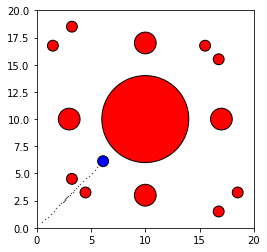

In [ ]:
# Single experiment
obstacles, robot = simulate(algorithm=ALGORITHM, ob_conf=OBSTACLES_CONF, startx=START_X, starty=START_Y, goalx=GOAL_X, goaly=GOAL_Y, n_obstacles=N_OBSTACLES)

if UNSAFE_PATH > 5:
    print(f'Failed to find a safe path! {UNSAFE_PATH} insecurities! Check the video to find out what happened.\n')
else:
    print(f'Safe Path found! {UNSAFE_PATH} insecurities! Let\'s create a video of the solution!\n')

create_video(ALGORITHM +'_'+ OBSTACLES_CONF +'.mp4')

### Experiments statistical study


Here you can perform a more in-depth statistical study

#### VO Study: rate of non-collision

In [ ]:
N_EXPERIMENTS = 300
obs = 20
ALGORITHM = 'vo'

print('############################## STATISTICAL STUDY USING VO ##############################')
for ob in range(1, obs+1):
  N_OBSTACLES = ob
  print(f'------------------------------ USING {N_OBSTACLES} OBSTACLES ------------------------------')
  # reach goal
  n = 0
  for _ in tqdm(range(N_EXPERIMENTS)):
    obstacles, robot = simulate(algorithm='vo', ob_conf='random', startx=0.5, starty=0.5, goalx=9.5, goaly=9.5, n_obstacles=N_OBSTACLES)
    if UNSAFE_PATH <= 5:
      n += 1
  print(f'The robot found a safe path in the {n/N_EXPERIMENTS*100}% of the "reach" experiments!\n')
  # stay still
  n = 0
  for _ in tqdm(range(N_EXPERIMENTS)):
    obstacles, robot = simulate(algorithm='vo', ob_conf='random', startx=5, starty=5, goalx=5, goaly=5, n_obstacles=N_OBSTACLES)
    if UNSAFE_PATH <= 5:
      n += 1
  print(f'\nThe robot found a safe path in the {n/N_EXPERIMENTS*100}% of the "stay still" experiments!\n\n')

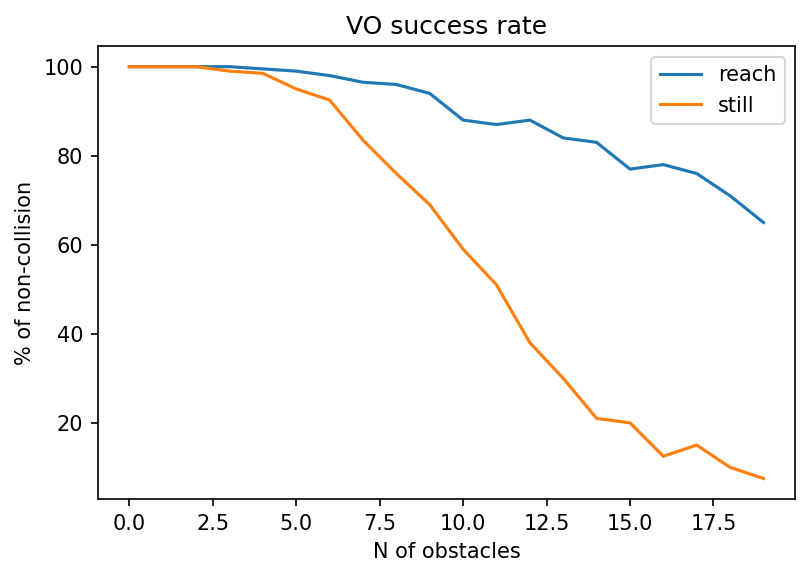

In [ ]:
reach = [100, 100, 100, 100, 99.5, 99, 98, 96.5, 96, 94, 88, 87, 88, 84, 83, 77, 78, 76, 71, 65]
still = [100, 100, 100, 99, 98.5, 95, 92.5, 83.5, 76, 69, 59, 51, 38, 30, 21, 20, 12.5, 15, 10, 7.5]
plt.figure(dpi=150)
plt.plot(reach)
plt.plot(still)
plt.title('VO success rate')
plt.ylabel('% of non-collision')
plt.xlabel('N of obstacles')
plt.legend(['reach', 'still'], loc='upper right')
plt.show()

#### NMPC Study: selected cost

In [ ]:
N_EXPERIMENTS = 300
obs = 20
ALGORITHM = 'nmpc'

print('############################## STATISTICAL STUDY USING nmpc ##############################')
for ob in range(1, obs+1):
  N_OBSTACLES = ob
  print(f'------------------------------ USING {N_OBSTACLES} OBSTACLES ------------------------------')
  # reach goal
  selected_cost = []
  for _ in tqdm(range(N_EXPERIMENTS)):
    obstacles, robot = simulate(algorithm='nmpc', ob_conf='random', startx=0.5, starty=0.5, goalx=9.5, goaly=9.5, n_obstacles=N_OBSTACLES)
  # in this case, selected_cost was not restarted to [] at the beginning of simulate
  selected_cost = np.array(selected_cost)
  cost_mean = np.mean(selected_cost)
  print(f'The robot found a safe path with a mean cost of {cost_mean:0.4} in the "reach" experiments!\n')
  # stay still
  selected_cost = []
  for _ in tqdm(range(N_EXPERIMENTS)):
    obstacles, robot = simulate(algorithm='nmpc', ob_conf='random', startx=5, starty=5, goalx=5, goaly=5, n_obstacles=N_OBSTACLES)
  # in this case, selected_cost was not restarted to [] at the beginning of simulate
  selected_cost = np.array(selected_cost)
  cost_mean = np.mean(selected_cost)
  print(f'The robot found a safe path with a mean cost of {cost_mean:0.4} in the "still" experiments!\n') 

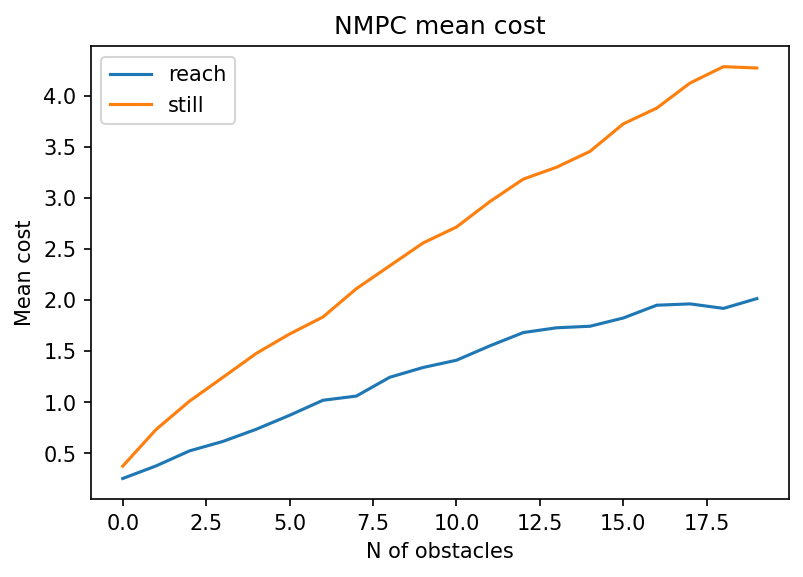

In [ ]:
reach = [0.2515, 0.375, 0.5218, 0.6146, 0.7338, 0.8708, 1.018, 1.059, 1.243, 1.339, 1.41, 1.551, 1.681, 1.728, 1.743, 1.824, 1.949, 1.962, 1.918, 2.014]
still = [0.3727, 0.732, 1.009, 1.242, 1.477, 1.667, 1.834, 2.111, 2.335, 2.559, 2.715, 2.964, 3.184, 3.301, 3.456, 3.726, 3.88, 4.126, 4.286, 4.273]
plt.figure(dpi=150)
plt.plot(reach)
plt.plot(still)
plt.title('NMPC mean cost')
plt.ylabel('Mean cost')
plt.xlabel('N of obstacles')
plt.legend(['reach', 'still'], loc='upper left')
plt.show()

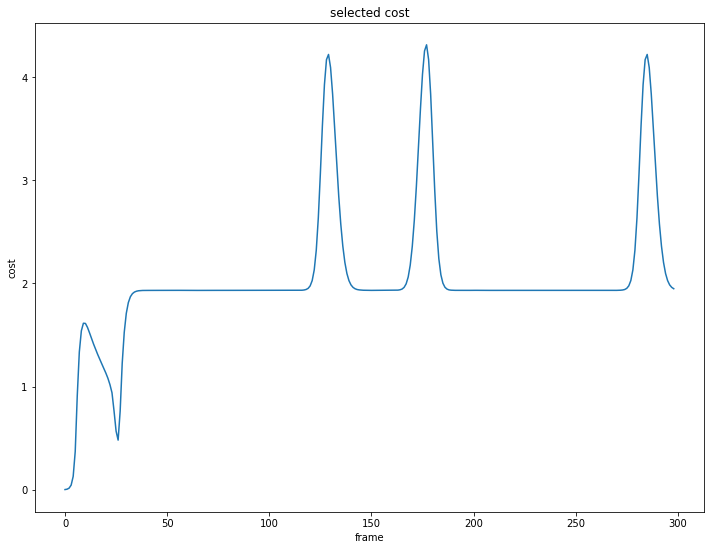

In [ ]:
# use this after a single experiment
# plot the cost of the velocity chosen in every timestep
plt.figure(figsize = (12, 9))
plt.plot(selected_cost)
plt.title('selected cost')
plt.ylabel('cost')
plt.xlabel('frame')
plt.show()

## Plots for report

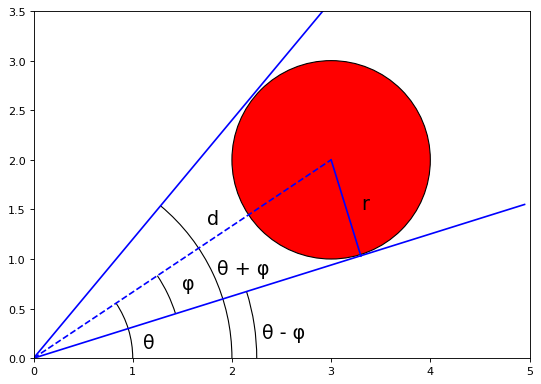

In [ ]:
# plot for report
figure(figsize=(8, 8), dpi=80)

def get_angle_plot(line1, line2, offset=1, color=None, origin=(0, 0), len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = str(angle)+u"\u00b0")

plt.xlim([0, 5])
plt.ylim([0, 3.5])
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().add_patch(Circle([3,2], 1, facecolor='red', edgecolor='black'))

line1 = Line2D([0,4.95], [0,1.55], color="b")
plt.gca().add_line(line1)

line2= Line2D([0,5], [0,6], color="b")
plt.gca().add_line(line2)

line3= Line2D([0,3], [0,2], color="b", linestyle = "--")
plt.gca().add_line(line3)

linex=Line2D([0,1], [0,0])
liney=Line2D([0,0], [0,1])
plt.plot([3,3.3], [2,1.03], 'b')


angle_plot = get_angle_plot(line3, linex, 1, color='black', len_x_axis=2, len_y_axis=2)
plt.gca().add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line1, line3, 1, color='black', len_x_axis=3, len_y_axis=3)
plt.gca().add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line2, linex, 1, color='black', len_x_axis=4, len_y_axis=4)
plt.gca().add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line1, linex, 1, color='black', len_x_axis=4.5, len_y_axis=4.5)
plt.gca().add_patch(angle_plot) # To display the angle arc

plt.gca().text(1.75,1.35, 'd', fontdict={'size': 'xx-large'})
plt.gca().text(3.3,1.5, 'r', fontdict={'size': 'xx-large'})
plt.gca().text(1.1,0.1, 'θ', fontdict={'size': 'xx-large'})
plt.gca().text(1.5,0.7, 'φ', fontdict={'size': 'xx-large'})
plt.gca().text(2.3,0.2, 'θ - φ', fontdict={'size': 'xx-large'})
plt.gca().text(1.85,0.85, 'θ + φ', fontdict={'size': 'xx-large'})

plt.show()

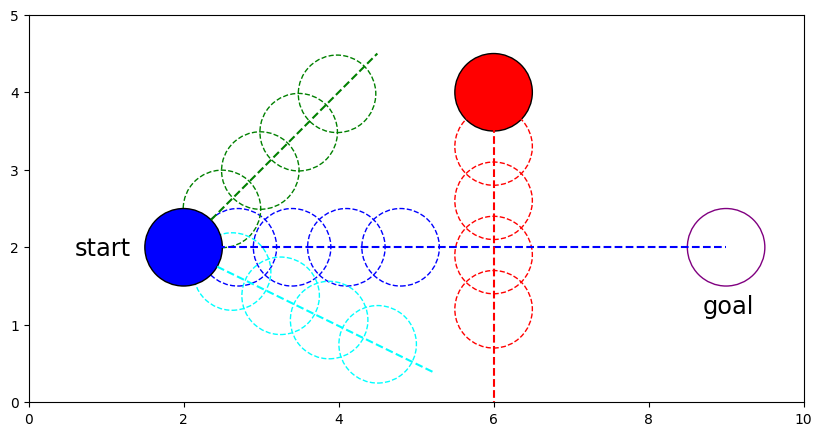

In [ ]:
# plot for report
figure(figsize=(10, 10), dpi=100)
plt.xlim([0, 10])
plt.ylim([0, 5])
plt.gca().set_aspect('equal', adjustable='box')

plt.gca().add_patch(Circle([9,2], 0.5, facecolor='white', edgecolor='purple'))

plt.gca().add_patch(Circle([6,4], 0.5, facecolor='red', edgecolor='black'))
plt.gca().add_patch(Circle([6,3.3], 0.5, edgecolor='red', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([6,2.6], 0.5, edgecolor='red', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([6,1.9], 0.5, edgecolor='red', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([6,1.2], 0.5, edgecolor='red', linestyle = "--", fill=False))

plt.gca().add_patch(Circle([2.7,2], 0.5, edgecolor='blue', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([3.4,2], 0.5, edgecolor='blue', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([4.1,2], 0.5, edgecolor='blue', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([4.8,2], 0.5, edgecolor='blue', linestyle = "--", fill=False))

plt.gca().add_patch(Circle([2.495,2.495], 0.5, edgecolor='green', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([2.99,2.99], 0.5, edgecolor='green', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([3.485,3.485], 0.5, edgecolor='green', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([3.98,3.98], 0.5, edgecolor='green', linestyle = "--", fill=False))

plt.gca().add_patch(Circle([2.626,1.687], 0.5, edgecolor='aqua', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([3.252,1.374], 0.5, edgecolor='aqua', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([3.878,1.061], 0.5, edgecolor='aqua', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([4.504,0.748], 0.5, edgecolor='aqua', linestyle = "--", fill=False))
plt.gca().add_patch(Circle([2,2], 0.5, facecolor='blue', edgecolor='black'))

line1 = Line2D([2,9], [2,2], color="b", linestyle = "--")
plt.gca().add_line(line1)
line2 = Line2D([6,6], [4,0], color="r", linestyle = "--")
plt.gca().add_line(line2)
line3 = Line2D([2+math.sqrt(2)/4,4.5], [2+math.sqrt(2)/4,4.5], color="g", linestyle = "--")
plt.gca().add_line(line3)
line4 = Line2D([2+math.sqrt(3)/4,5.25], [2-1/4,0.375], color="aqua", linestyle = "--")
plt.gca().add_line(line4)

#plt.plot([3,3.3], [2,1.03], 'b')

plt.gca().text(0.6,1.9, 'start', fontdict={'size': 'xx-large'})
plt.gca().text(8.7,1.15, 'goal', fontdict={'size': 'xx-large'})

plt.show()